In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image,ImageOps
import PIL
from skimage.metrics import peak_signal_noise_ratio
import skimage.measure
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
path = './test_data/'
img_down_name = "uhr1"
img_up_name = "uhr2"
img_name_original = "ooflapl"

img_original_path = path + img_name_original + ".jpg"
img_down_path = path + img_down_name + ".jpg"
img_up_path = path + img_up_name + ".jpg"

img_original_pil = Image.open(img_original_path)
img_up_pil = Image.open(img_up_path)
img_down_pil = Image.open(img_down_path)

img_original_pil = img_original_pil.resize((512,512),Image.ANTIALIAS)
img_up_pil = img_up_pil.resize((512,512),Image.ANTIALIAS)
img_down_pil = img_down_pil.resize((512,512),Image.ANTIALIAS)

img_original_pil = ImageOps.grayscale(img_original_pil)
img_up_pil = ImageOps.grayscale(img_up_pil)
img_down_pil = ImageOps.grayscale(img_down_pil)

img_original_np = pil_to_np(img_original_pil)
img_up_np = pil_to_np(img_up_pil)
img_down_np = pil_to_np(img_down_pil)

print(img_up_np.shape)

img_clean_var = np_to_var(img_original_np).type(dtype)

(1, 512, 512)


In [3]:
# def get_noisy_img(sig=30,noise_same = False):
#     sigma = sig/255.
#     if noise_same: # add the same noise in each channel
#         noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
#         noise = np.array( [noise]*img_np.shape[0] )
#     else: # add independent noise in each channel
#         noise = np.random.normal(scale=sigma, size=img_np.shape)

#     img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float64)
#     img_noisy_var = np_to_var(img_noisy_np).type(dtype)
#     return img_noisy_np,img_noisy_var
    
# img_noisy_np,img_noisy_var = get_noisy_img()  
# output_depth = img_np.shape[0] 
# print("Image size: ", img_np.shape)

In [4]:
output_depth = img_original_np.shape[0]
def denoise(img_noisy_var_one,img_noisy_var_two,k=128,numit = 1000,rn = 0.0,find_best=True,upsample_first = True):
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=upsample_first).type(dtype)
    mse_n, mse_t, ni, net = fit_fusion( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var_one=img_noisy_var_one,
                        img_noisy_var_two=img_noisy_var_two,
                        net=net,
                        img_clean_var=img_clean_var,
                        find_best=find_best
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t

shape:  [1, 128, 16, 16]
optimize with adam 0.01


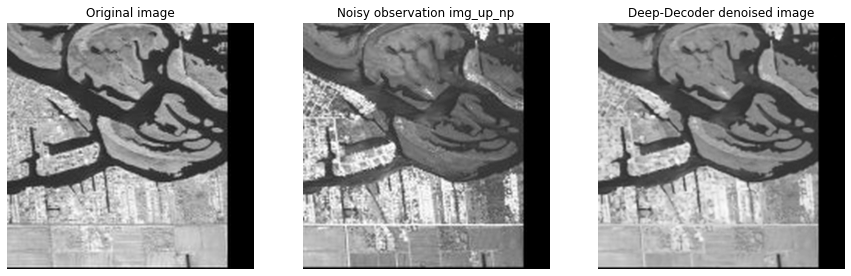

In [5]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),cmap = matplotlib.cm.gray)

def plot_results(out_img_np,img_np,img_up_np):
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,img_up_np)
    ax2.set_title( "Noisy observation img_up_np" )
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3,out_img_np)
    ax3.set_title( "Deep-Decoder denoised image"  ) 
    ax3.axis('off') 

    
    plt.show()

img_blur_var_up = np_to_var(img_up_np).type(dtype)
img_blur_var_down = np_to_var(img_down_np).type(dtype)



# img_noisy_np,img_noisy_var = get_noisy_img(sig=30,noise_same = False)
out_img_np, mse_t = denoise(img_blur_var_up,img_blur_var_down,k=128,numit = 5000,rn = 0.0)

plot_results(out_img_np,img_up_np,img_down_np)

In [6]:
plt.imsave("DD_remote_fusion_remosensoing.jpg",out_img_np[0],cmap='gray')

In [7]:

print(peak_signal_noise_ratio(out_img_np,img_original_np))
print(out_img_np)

25.146428992362537
[[[5.5102122e-01 5.5176044e-01 5.5348742e-01 ... 2.4010360e-04
   2.4528831e-04 2.4792401e-04]
  [5.5096549e-01 5.5171937e-01 5.5351353e-01 ... 2.4267133e-04
   2.4788338e-04 2.5053672e-04]
  [5.5085397e-01 5.5174071e-01 5.5356580e-01 ... 2.4779452e-04
   2.5312114e-04 2.5582805e-04]
  ...
  [1.4947431e-01 1.4957476e-01 1.4977570e-01 ... 2.4036324e-06
   2.2814916e-06 2.2227616e-06]
  [4.4332366e-02 4.4328213e-02 4.4333294e-02 ... 2.2711583e-06
   2.1552089e-06 2.0994871e-06]
  [2.4618417e-02 2.4604708e-02 2.4577357e-02 ... 2.2076756e-06
   2.0947273e-06 2.0404352e-06]]]


In [8]:
def find_x_square_index(input_img_np):
    mean = np.mean(input_img_np)
    sum_t = 0
    for i in range(128):
        for j in range(128):
            sum_t += (input_img_np[0][i][j]-mean)**2
    return sum_t/16384         

print(find_x_square_index(out_img_np))


def find_x_y_index(input_img_np_one,input_img_np_two):
    mean_one = np.mean(input_img_np_one)
    mean_two = np.mean(input_img_np_two)
    sum_t = 0
    for i in range(128):
        for j in range(128):
            sum_t += (input_img_np_one[0][i][j]-mean_one)*(input_img_np_two[0][i][j]-mean_two)
    return sum_t/16384  

print(find_x_y_index(img_up_np,out_img_np)) 


0.0273895902338749
0.03271419365396828


In [9]:
def find_Q_zero(input_img_np_one,input_img_np_two):
    mean_one = np.mean(input_img_np_one)
    mean_two = np.mean(input_img_np_two)
    theta_xy = find_x_y_index(input_img_np_one,input_img_np_two)
    theta_x_square = find_x_square_index(input_img_np_one)
    theta_y_square = find_x_square_index(input_img_np_two)
    result = (4*theta_xy*mean_one*mean_two)/(((mean_one**2)+(mean_two**2))*(theta_x_square+theta_y_square))
    return result

print(find_Q_zero(img_up_np,out_img_np)) 

0.9495677263071132


In [10]:
def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)
    
def find_fusion_index(input_img_one,input_img_two,fusion_result):
    entropy_one = skimage.measure.shannon_entropy(input_img_one)
    entropy_two = skimage.measure.shannon_entropy(input_img_two)
    lambda_one = entropy_one/(entropy_one+entropy_two)
    lambda_two = 1-lambda_one

    img_original_np = pil_to_np(fusion_result)
    img_up_np = pil_to_np(input_img_one)
    img_down_np = pil_to_np(input_img_two)
    
    q_zero_one = find_Q_zero(img_up_np,img_original_np)
    q_zero_two = find_Q_zero(img_down_np,img_original_np)

    result = lambda_one * q_zero_one + lambda_two * q_zero_two

    return result

print(find_fusion_index(img_up_pil,img_down_pil,np_to_pil(out_img_np)))
# img_original_pil = ImageOps.grayscale(img_original_pil)
# img_up_pil = ImageOps.grayscale(img_up_pil)
# img_down_pil = ImageOps.grayscale(img_down_pil)


0.9356776005970413
